# Import module

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sys
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18




Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


  * could not import Bokeh, plotting with Highcharts instead.
- no local installation of highcharts found, using web version.
- loading highcharts...


* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
tools.tools                                   (211209-10:18)
- no local installation of JSME found, using web version.
* SA scorer not available. RDKit's Contrib dir needs to be in the Python import path...
> interactive IPython session.
tools.sar                                     (211209-10:18)


# Load sdf file

In [2]:
# Function to read SDF file into DataFrame
def load_sdf_to_df(filename):
    suppl = Chem.SDMolSupplier(filename)
    rows = []
    for mol in suppl:
        if mol is not None:
            row = {prop: mol.GetProp(prop) for prop in mol.GetPropNames()}
            row['SMILES'] = Chem.MolToSmiles(mol)
            rows.append(row)
    return pd.DataFrame(rows)

# Load the  test sets from SDF files
test_df = load_sdf_to_df('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/data/test_set_acute_inhalation_features.sdf')

# Convert strings back to lists of integers
def string_to_list(bit_string):
    if isinstance(bit_string, str):
        return list(map(int, bit_string.strip('[]').split(', ')))
    else:
        return bit_string


test_df['Morgan_Descriptors'] = test_df['Morgan_Descriptors'].apply(string_to_list)
test_df['MACCS_Descriptors'] = test_df['MACCS_Descriptors'].apply(string_to_list)

def string_to_list(descriptor):
    if isinstance(descriptor, str):
        return list(map(float, descriptor.strip('[]').split(',')))
    return descriptor

# Apply the function to the 'Modred_Descriptor' column
test_df['Modred_Descriptor'] = test_df['Modred_Descriptor'].apply(string_to_list)

# Convert 'Modred_Descriptor' column to a NumPy array
data_modred_test = np.array(test_df['Modred_Descriptor'].tolist())


print("Test DataFrame:")
print(test_df.head())


Test DataFrame:
     id       casrn smiles (First)    Molecular weight  \
0  2564     64-19-7                  60.05195999145508   
1  1454    110-76-9                  90.14418029785156   
2  3979     75-76-3                  88.22357940673828   
3  1715    382-10-5                 164.04910278320312   
4   610  77501-63-4                  461.7731018066406   

                                            name Outcome  \
0                                    acetic acid       1   
1                             2-ethoxyethanamine       0   
2                              tetramethylsilane       0   
3  3,3,3-trifluoro-2-(trifluoromethyl)prop-1-ene       1   
4                                              -       0   

                   Molecule (RDKit Mol) (InChI Code) reference molecule_form  \
0              InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)      ECHA             V   
1           InChI=1S/C4H11NO/c1-2-6-4-3-5/h2-5H2,1H3      ECHA             V   
2                 InChI=1S/C4H12Si

In [3]:
data_modred_test.shape

(136, 742)

In [4]:
test_df

,id,casrn,smiles (First),Molecular weight,name,Outcome,Molecule (RDKit Mol) (InChI Code),reference,molecule_form,ID,RowID,Morgan_Descriptors,MACCS_Descriptors,Modred_Descriptor,SMILES
0,2564,64-19-7,,60.05195999145508,acetic acid,1,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)",ECHA,V,,282,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.9933128039738658, -1.3775249672735086, -1....",CC(=O)O
1,1454,110-76-9,,90.14418029785156,2-ethoxyethanamine,0,"InChI=1S/C4H11NO/c1-2-6-4-3-5/h2-5H2,1H3",ECHA,V,,183,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.6664701743087265, -1.1234632059758975, -1....",CCOCCN
2,3979,75-76-3,,88.22357940673828,tetramethylsilane,0,"InChI=1S/C4H12Si/c1-5(2,3)4/h1-4H3",ECHA,V,,202,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.9436069176306845, -0.4034423242722519, -0....",C[Si](C)(C)C
3,1715,382-10-5,,164.04910278320312,"3,3,3-trifluoro-2-(trifluoromethyl)prop-1-ene",1,"InChI=1S/C4H2F6/c1-2(3(5,6)7)4(8,9)10/h1H2",ECHA,G,,574,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.42262963094180434, 0.8122623498165246, 0.8...",C=C(C(F)(F)F)C(F)(F)F
4,610,77501-63-4,,461.7731018066406,-,0,InChI=1S/C19H15ClF3NO7/c1-3-29-17(25)10(2)30-1...,ECHA,A,,403,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.129359201551034, 1.0946350088527885, 1.1574...",CCOC(=O)C(C)OC(=O)c1cc(Oc2ccc(C(F)(F)F)cc2Cl)c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,1282,608-27-5,,162.0166015625,"2,3-dichloroaniline",0,"InChI=1S/C6H5Cl2N/c7-4-2-1-3-5(9)6(4)8/h1-3H,9H2",ECHA,A,,392,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.3044191366201352, 0.5556329132905385, 0.60...",Nc1cccc(Cl)c1Cl
132,3557; 3562; 3558; 3546; 3548; 3547; 3540; 3561...,111-66-0,,112.212646484375,oct-1-ene,0,"InChI=1S/C8H16/c1-3-5-7-8-6-4-2/h3H,1,4-8H2,2H3",ECHA,V,,244,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.4318414936042256, -0.8419162812515544, -0....",C=CCCCCCC
133,1762,111-17-1,,178.20620727539062,3-[(2-carboxyethyl)sulfanyl]propanoic acid,0,InChI=1S/C6H10O4S/c7-5(8)1-3-11-4-2-6(9)10/h1-...,ECHA,A,,541,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.19651573498989172, -0.4034423242722535, -0...",O=C(O)CCSCCC(=O)O
134,3637,111-64-8,,162.6571044921875,octanoyl chloride,1,InChI=1S/C8H15ClO/c1-2-3-4-5-6-7-8(9)10/h2-7H2...,ECHA,V,,284,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.2625661755257653, -0.5138998626191942, -0....",CCCCCCCC(=O)Cl


# Data distribution

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


outcomes=(np.unique(test_df['Outcome']))
le.fit(list(set(outcomes)))
y = le.transform( test_df['Outcome'] )



print ("Classes                          : ",(outcomes))
print ("Number of cpds in each class     : ",np.unique([len(y[y==smi]) for smi in y]))
print ("Total number of cpds             : ",len(y))

S = test_df['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)

Classes                          :  ['0' '1']
Number of cpds in each class     :  [59 77]
Total number of cpds             :  136


{'1': 0, '0': 1}

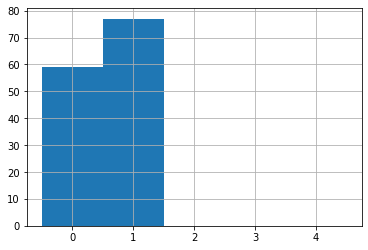

In [6]:
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info

# Load Model

In [75]:
import joblib
rf_morgan = joblib.load('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_SVM_morgan.pkl')  # Assume these are trained or loaded
rf_maccs = joblib.load('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_XGB_maccskey.pkl')
rf_modred = joblib.load('E:/stoptox-master/stoptox-master/modeling/Projeto_2_Acute_Inhalation/model/model_toxic/Model_inhalation_toxicity_RF_modred.pkl')


# Model Evaluation 

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report


In [12]:
y_true = test_df['Outcome'].astype(int)  # Ensure it's of integer type, suitable for metrics calculation


In [76]:
# Consensus with probability average 

def predict_with_models_probabilities(moldf):
    # Assuming `predict_proba` method is available and returns probabilities for the positive class
    morgan_probs = rf_morgan.predict_proba(np.array(list(test_df['Morgan_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    maccs_probs = rf_maccs.predict_proba(np.array(list(test_df['MACCS_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    modred_probs = rf_modred.predict_proba(np.array(list(test_df['Modred_Descriptor'].values)))[:, 1]  # Probabilities for class 1

    # Calculate the mean probability across all models
  #  mean_probs = np.mean([morgan_probs, maccs_probs, modred_probs], axis=0)
   # mean_probs = np.mean([morgan_probs, maccs_probs], axis=0)
    mean_probs = np.mean([maccs_probs, modred_probs], axis=0)
    # Convert mean probabilities to final class predictions (e.g., threshold at 0.5)
    final_predictions = (mean_probs > 0.5).astype(int)
    
    return final_predictions

# Run prediction
final_predictions = predict_with_models_probabilities(test_df)
test_df['Predictions'] = final_predictions

print(test_df[['SMILES', 'Predictions']])

                                                SMILES  Predictions
0                                              CC(=O)O            1
1                                               CCOCCN            1
2                                         C[Si](C)(C)C            0
3                                C=C(C(F)(F)F)C(F)(F)F            0
4    CCOC(=O)C(C)OC(=O)c1cc(Oc2ccc(C(F)(F)F)cc2Cl)c...            0
..                                                 ...          ...
131                                    Nc1cccc(Cl)c1Cl            1
132                                          C=CCCCCCC            0
133                                  O=C(O)CCSCCC(=O)O            0
134                                     CCCCCCCC(=O)Cl            1
135                                          NNC(=S)NN            1

[136 rows x 2 columns]


In [126]:
moldf

,name,Outcome,SMILES,ID,Mol,Morgan_Descriptors,MACCS_Descriptors,Predictions
0,3-azidosulfonylbenzoic acid,0,[N-]=[N+]=NS(=O)(=O)c1cccc(C(=O)O)c1,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,sodium;5-[2-chloro-4-(trifluoromethyl)phenoxy]...,0,O=C([O-])c1cc(Oc2ccc(C(F)(F)F)cc2Cl)ccc1[N+](=...,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,2-cyclohexyl-6-[(3-cyclohexyl-2-hydroxy-5-meth...,0,Cc1cc(Cc2cc(C)cc(C3CCCCC3)c2O)c(O)c(C2CCCCC2)c1,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4-chloro-1-methylpiperidine;hydrochloride,1,CN1CCC(Cl)CC1.Cl,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,1-(diaminomethylidene)-2-(2-methylphenyl)guani...,0,Cc1ccccc1N=C(N)N=C(N)N,,<rdkit.Chem.rdchem.Mol object at 0x00000248AD7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...,...,...
729,2-butyloctanoic acid,0,CCCCCCC(CCCC)C(=O)O,,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
730,propan-2-olate;titanium(4+),0,CC(C)[O-].CC(C)[O-].CC(C)[O-].CC(C)[O-].[Ti+4],,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
731,dichloro(phenyl)arsane,1,Cl[As](Cl)c1ccccc1,,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
732,"1,1-dichloroprop-1-ene",0,CC=C(Cl)Cl,,<rdkit.Chem.rdchem.Mol object at 0x00000248AED...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


# Metrics Performance Consensus

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#RF RF RF
# Assuming y_true and final_predictions are defined
conf_matrix = confusion_matrix(y_true, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_true, final_predictions)
print("Accuracy:", accuracy)

# Assuming you have probabilities (modify if you only have labels)
# For labels only:
auc_score = roc_auc_score(y_true, final_predictions)
print("AUC Score:", auc_score)

f1 = f1_score(y_true, final_predictions, average='binary')  # For binary classification
print("F1 Score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Correct Classification Rate (CCR)
ccr = (sensitivity + specificity) / 2
print("CCR (Correct Classification Rate):", ccr)

# Positive Predictive Value (PPV)
ppv = tp / (tp + fp)
print("PPV (Positive Predictive Value):", ppv)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print("NPV (Negative Predictive Value):", npv)


Confusion Matrix:
[[57 20]
 [14 45]]
Accuracy: 0.75
AUC Score: 0.7514858023332599
F1 Score: 0.7258064516129032
Sensitivity: 0.7627118644067796
Specificity: 0.7402597402597403
CCR (Correct Classification Rate): 0.75148580233326
PPV (Positive Predictive Value): 0.6923076923076923
NPV (Negative Predictive Value): 0.8028169014084507


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#XGB XGB XGB
# Assuming y_true and final_predictions are defined
conf_matrix = confusion_matrix(y_true, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_true, final_predictions)
print("Accuracy:", accuracy)

# Assuming you have probabilities (modify if you only have labels)
# For labels only:
auc_score = roc_auc_score(y_true, final_predictions)
print("AUC Score:", auc_score)

f1 = f1_score(y_true, final_predictions, average='binary')  # For binary classification
print("F1 Score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Correct Classification Rate (CCR)
ccr = (sensitivity + specificity) / 2
print("CCR (Correct Classification Rate):", ccr)

# Positive Predictive Value (PPV)
ppv = tp / (tp + fp)
print("PPV (Positive Predictive Value):", ppv)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print("NPV (Negative Predictive Value):", npv)


Confusion Matrix:
[[56 21]
 [14 45]]
Accuracy: 0.7426470588235294
AUC Score: 0.7449922958397535
F1 Score: 0.7199999999999999
Sensitivity: 0.7627118644067796
Specificity: 0.7272727272727273
CCR (Correct Classification Rate): 0.7449922958397535
PPV (Positive Predictive Value): 0.6818181818181818
NPV (Negative Predictive Value): 0.8


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#SVM SVM SVM
# Assuming y_true and final_predictions are defined
conf_matrix = confusion_matrix(y_true, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_true, final_predictions)
print("Accuracy:", accuracy)

# Assuming you have probabilities (modify if you only have labels)
# For labels only:
auc_score = roc_auc_score(y_true, final_predictions)
print("AUC Score:", auc_score)

f1 = f1_score(y_true, final_predictions, average='binary')  # For binary classification
print("F1 Score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Correct Classification Rate (CCR)
ccr = (sensitivity + specificity) / 2
print("CCR (Correct Classification Rate):", ccr)

# Positive Predictive Value (PPV)
ppv = tp / (tp + fp)
print("PPV (Positive Predictive Value):", ppv)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print("NPV (Negative Predictive Value):", npv)


Confusion Matrix:
[[56 21]
 [12 47]]
Accuracy: 0.7573529411764706
AUC Score: 0.7619414483821264
F1 Score: 0.7401574803149606
Sensitivity: 0.7966101694915254
Specificity: 0.7272727272727273
CCR (Correct Classification Rate): 0.7619414483821263
PPV (Positive Predictive Value): 0.6911764705882353
NPV (Negative Predictive Value): 0.8235294117647058


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#RF SVM XGB
# Assuming y_true and final_predictions are defined
conf_matrix = confusion_matrix(y_true, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_true, final_predictions)
print("Accuracy:", accuracy)

# Assuming you have probabilities (modify if you only have labels)
# For labels only:
auc_score = roc_auc_score(y_true, final_predictions)
print("AUC Score:", auc_score)

f1 = f1_score(y_true, final_predictions, average='binary')  # For binary classification
print("F1 Score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Correct Classification Rate (CCR)
ccr = (sensitivity + specificity) / 2
print("CCR (Correct Classification Rate):", ccr)

# Positive Predictive Value (PPV)
ppv = tp / (tp + fp)
print("PPV (Positive Predictive Value):", ppv)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print("NPV (Negative Predictive Value):", npv)


Confusion Matrix:
[[60 17]
 [14 45]]
Accuracy: 0.7720588235294118
AUC Score: 0.7709663218137794
F1 Score: 0.743801652892562
Sensitivity: 0.7627118644067796
Specificity: 0.7792207792207793
CCR (Correct Classification Rate): 0.7709663218137794
PPV (Positive Predictive Value): 0.7258064516129032
NPV (Negative Predictive Value): 0.8108108108108109


In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#SVM RF
# Assuming y_true and final_predictions are defined
conf_matrix = confusion_matrix(y_true, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_true, final_predictions)
print("Accuracy:", accuracy)

# Assuming you have probabilities (modify if you only have labels)
# For labels only:
auc_score = roc_auc_score(y_true, final_predictions)
print("AUC Score:", auc_score)

f1 = f1_score(y_true, final_predictions, average='binary')  # For binary classification
print("F1 Score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Correct Classification Rate (CCR)
ccr = (sensitivity + specificity) / 2
print("CCR (Correct Classification Rate):", ccr)

# Positive Predictive Value (PPV)
ppv = tp / (tp + fp)
print("PPV (Positive Predictive Value):", ppv)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print("NPV (Negative Predictive Value):", npv)


Confusion Matrix:
[[61 16]
 [13 46]]
Accuracy: 0.7867647058823529
AUC Score: 0.7859344045784724
F1 Score: 0.7603305785123968
Sensitivity: 0.7796610169491526
Specificity: 0.7922077922077922
CCR (Correct Classification Rate): 0.7859344045784724
PPV (Positive Predictive Value): 0.7419354838709677
NPV (Negative Predictive Value): 0.8243243243243243


In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#SVM SVM 
# Assuming y_true and final_predictions are defined
conf_matrix = confusion_matrix(y_true, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_true, final_predictions)
print("Accuracy:", accuracy)

# Assuming you have probabilities (modify if you only have labels)
# For labels only:
auc_score = roc_auc_score(y_true, final_predictions)
print("AUC Score:", auc_score)

f1 = f1_score(y_true, final_predictions, average='binary')  # For binary classification
print("F1 Score:", f1)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Correct Classification Rate (CCR)
ccr = (sensitivity + specificity) / 2
print("CCR (Correct Classification Rate):", ccr)

# Positive Predictive Value (PPV)
ppv = tp / (tp + fp)
print("PPV (Positive Predictive Value):", ppv)

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)
print("NPV (Negative Predictive Value):", npv)


Confusion Matrix:
[[55 22]
 [12 47]]
Accuracy: 0.75
AUC Score: 0.7554479418886199
F1 Score: 0.7343750000000001
Sensitivity: 0.7966101694915254
Specificity: 0.7142857142857143
CCR (Correct Classification Rate): 0.7554479418886199
PPV (Positive Predictive Value): 0.6811594202898551
NPV (Negative Predictive Value): 0.8208955223880597


# Individual testing

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#5compounds RF
def predict_with_models_probabilities(moldf):
    # Assuming `predict_proba` method is available and returns probabilities for the positive class
    morgan_probs = rf_morgan.predict_proba(np.array(list(test_df['Morgan_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    maccs_probs = rf_maccs.predict_proba(np.array(list(test_df['MACCS_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    modred_probs = rf_modred.predict_proba(np.array(list(test_df['Modred_Descriptor'].values)))[:, 1]  # Probabilities for class 1

    # Convert probabilities to final class predictions (e.g., threshold at 0.5)
    morgan_predictions = (morgan_probs > 0.5).astype(int)
    maccs_predictions = (maccs_probs > 0.5).astype(int)
    modred_predictions = (modred_probs > 0.5).astype(int)
    
    return morgan_predictions, maccs_predictions, modred_predictions

def evaluate_performance(y_true, predictions):
    conf_matrix = confusion_matrix(y_true, predictions)
    accuracy = accuracy_score(y_true, predictions)
    auc_score = roc_auc_score(y_true, predictions)
    f1 = f1_score(y_true, predictions, average='binary')  # For binary classification

    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ccr = (sensitivity + specificity) / 2
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    return {
        "Confusion Matrix": conf_matrix,
        "Accuracy": accuracy,
        "AUC Score": auc_score,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "CCR (Correct Classification Rate)": ccr,
        "PPV (Positive Predictive Value)": ppv,
        "NPV (Negative Predictive Value)": npv
    }

# Run prediction
morgan_predictions, maccs_predictions, modred_predictions = predict_with_models_probabilities(test_df)

# Assuming y_true is defined
morgan_performance = evaluate_performance(y_true, morgan_predictions)
maccs_performance = evaluate_performance(y_true, maccs_predictions)
modred_performance = evaluate_performance(y_true, modred_predictions)

# Print performance for each model
print("Morgan Performance:")
for metric, value in morgan_performance.items():
    print(f"{metric}: {value}")

print("\nMACCS Performance:")
for metric, value in maccs_performance.items():
    print(f"{metric}: {value}")

print("\nModred Performance:")
for metric, value in modred_performance.items():
    print(f"{metric}: {value}")


Morgan Performance:
Confusion Matrix: [[51 26]
 [22 37]]
Accuracy: 0.6470588235294118
AUC Score: 0.6447281532027295
F1 Score: 0.6065573770491803
Sensitivity: 0.6271186440677966
Specificity: 0.6623376623376623
CCR (Correct Classification Rate): 0.6447281532027295
PPV (Positive Predictive Value): 0.5873015873015873
NPV (Negative Predictive Value): 0.6986301369863014

MACCS Performance:
Confusion Matrix: [[55 22]
 [11 48]]
Accuracy: 0.7573529411764706
AUC Score: 0.7639225181598063
F1 Score: 0.744186046511628
Sensitivity: 0.8135593220338984
Specificity: 0.7142857142857143
CCR (Correct Classification Rate): 0.7639225181598064
PPV (Positive Predictive Value): 0.6857142857142857
NPV (Negative Predictive Value): 0.8333333333333334

Modred Performance:
Confusion Matrix: [[61 16]
 [16 43]]
Accuracy: 0.7647058823529411
AUC Score: 0.7605106757649129
F1 Score: 0.7288135593220338
Sensitivity: 0.7288135593220338
Specificity: 0.7922077922077922
CCR (Correct Classification Rate): 0.760510675764913
PPV 

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#XGB XGB XGB
def predict_with_models_probabilities(moldf):
    # Assuming `predict_proba` method is available and returns probabilities for the positive class
    morgan_probs = rf_morgan.predict_proba(np.array(list(test_df['Morgan_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    maccs_probs = rf_maccs.predict_proba(np.array(list(test_df['MACCS_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    modred_probs = rf_modred.predict_proba(np.array(list(test_df['Modred_Descriptor'].values)))[:, 1]  # Probabilities for class 1

    # Convert probabilities to final class predictions (e.g., threshold at 0.5)
    morgan_predictions = (morgan_probs > 0.5).astype(int)
    maccs_predictions = (maccs_probs > 0.5).astype(int)
    modred_predictions = (modred_probs > 0.5).astype(int)
    
    return morgan_predictions, maccs_predictions, modred_predictions

def evaluate_performance(y_true, predictions):
    conf_matrix = confusion_matrix(y_true, predictions)
    accuracy = accuracy_score(y_true, predictions)
    auc_score = roc_auc_score(y_true, predictions)
    f1 = f1_score(y_true, predictions, average='binary')  # For binary classification

    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ccr = (sensitivity + specificity) / 2
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    return {
        "Confusion Matrix": conf_matrix,
        "Accuracy": accuracy,
        "AUC Score": auc_score,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "CCR (Correct Classification Rate)": ccr,
        "PPV (Positive Predictive Value)": ppv,
        "NPV (Negative Predictive Value)": npv
    }

# Run prediction
morgan_predictions, maccs_predictions, modred_predictions = predict_with_models_probabilities(test_df)

# Assuming y_true is defined
morgan_performance = evaluate_performance(y_true, morgan_predictions)
maccs_performance = evaluate_performance(y_true, maccs_predictions)
modred_performance = evaluate_performance(y_true, modred_predictions)

# Print performance for each model
print("Morgan Performance:")
for metric, value in morgan_performance.items():
    print(f"{metric}: {value}")

print("\nMACCS Performance:")
for metric, value in maccs_performance.items():
    print(f"{metric}: {value}")

print("\nModred Performance:")
for metric, value in modred_performance.items():
    print(f"{metric}: {value}")


Morgan Performance:
Confusion Matrix: [[46 31]
 [20 39]]
Accuracy: 0.625
AUC Score: 0.6292097732775699
F1 Score: 0.6046511627906977
Sensitivity: 0.6610169491525424
Specificity: 0.5974025974025974
CCR (Correct Classification Rate): 0.6292097732775699
PPV (Positive Predictive Value): 0.5571428571428572
NPV (Negative Predictive Value): 0.696969696969697

MACCS Performance:
Confusion Matrix: [[53 24]
 [12 47]]
Accuracy: 0.7352941176470589
AUC Score: 0.7424609289016069
F1 Score: 0.7230769230769231
Sensitivity: 0.7966101694915254
Specificity: 0.6883116883116883
CCR (Correct Classification Rate): 0.7424609289016069
PPV (Positive Predictive Value): 0.6619718309859155
NPV (Negative Predictive Value): 0.8153846153846154

Modred Performance:
Confusion Matrix: [[61 16]
 [17 42]]
Accuracy: 0.7573529411764706
AUC Score: 0.7520360994937265
F1 Score: 0.717948717948718
Sensitivity: 0.711864406779661
Specificity: 0.7922077922077922
CCR (Correct Classification Rate): 0.7520360994937266
PPV (Positive Pred

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
#SVM SVM SVM
def predict_with_models_probabilities(moldf):
    # Assuming `predict_proba` method is available and returns probabilities for the positive class
    morgan_probs = rf_morgan.predict_proba(np.array(list(test_df['Morgan_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    maccs_probs = rf_maccs.predict_proba(np.array(list(test_df['MACCS_Descriptors'].values)))[:, 1]  # Probabilities for class 1
    modred_probs = rf_modred.predict_proba(np.array(list(test_df['Modred_Descriptor'].values)))[:, 1]  # Probabilities for class 1

    # Convert probabilities to final class predictions (e.g., threshold at 0.5)
    morgan_predictions = (morgan_probs > 0.5).astype(int)
    maccs_predictions = (maccs_probs > 0.5).astype(int)
    modred_predictions = (modred_probs > 0.5).astype(int)
    
    return morgan_predictions, maccs_predictions, modred_predictions

def evaluate_performance(y_true, predictions):
    conf_matrix = confusion_matrix(y_true, predictions)
    accuracy = accuracy_score(y_true, predictions)
    auc_score = roc_auc_score(y_true, predictions)
    f1 = f1_score(y_true, predictions, average='binary')  # For binary classification

    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ccr = (sensitivity + specificity) / 2
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    return {
        "Confusion Matrix": conf_matrix,
        "Accuracy": accuracy,
        "AUC Score": auc_score,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "CCR (Correct Classification Rate)": ccr,
        "PPV (Positive Predictive Value)": ppv,
        "NPV (Negative Predictive Value)": npv
    }

# Run prediction
morgan_predictions, maccs_predictions, modred_predictions = predict_with_models_probabilities(test_df)

# Assuming y_true is defined
morgan_performance = evaluate_performance(y_true, morgan_predictions)
maccs_performance = evaluate_performance(y_true, maccs_predictions)
modred_performance = evaluate_performance(y_true, modred_predictions)

# Print performance for each model
print("Morgan Performance:")
for metric, value in morgan_performance.items():
    print(f"{metric}: {value}")

print("\nMACCS Performance:")
for metric, value in maccs_performance.items():
    print(f"{metric}: {value}")

print("\nModred Performance:")
for metric, value in modred_performance.items():
    print(f"{metric}: {value}")


Morgan Performance:
Confusion Matrix: [[45 32]
 [17 42]]
Accuracy: 0.6397058823529411
AUC Score: 0.6481399955976227
F1 Score: 0.631578947368421
Sensitivity: 0.711864406779661
Specificity: 0.5844155844155844
CCR (Correct Classification Rate): 0.6481399955976227
PPV (Positive Predictive Value): 0.5675675675675675
NPV (Negative Predictive Value): 0.7258064516129032

MACCS Performance:
Confusion Matrix: [[59 18]
 [13 46]]
Accuracy: 0.7720588235294118
AUC Score: 0.7729473915914594
F1 Score: 0.7479674796747967
Sensitivity: 0.7796610169491526
Specificity: 0.7662337662337663
CCR (Correct Classification Rate): 0.7729473915914594
PPV (Positive Predictive Value): 0.71875
NPV (Negative Predictive Value): 0.8194444444444444

Modred Performance:
Confusion Matrix: [[59 18]
 [15 44]]
Accuracy: 0.7573529411764706
AUC Score: 0.7559982390490866
F1 Score: 0.7272727272727273
Sensitivity: 0.7457627118644068
Specificity: 0.7662337662337663
CCR (Correct Classification Rate): 0.7559982390490865
PPV (Positive P